In [1]:
%matplotlib inline

import h5py, pandas, cPickle, random, sys
import numpy as np

from molecules.utils import one_hot_array, one_hot_index, from_one_hot_array, \
    decode_smiles_from_indexes, load_dataset

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout, Input, Flatten, Reshape, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils

from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython import display

Using TensorFlow backend.


In [2]:
data = h5py.File('data/prep_500k.h5', 'r')
data_train = np.array(data['data_train'])
data_test = np.array(data['data_test'])
charset = data['charset']

In [3]:
def plot_loss(losses):
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='Discriminative loss')
    plt.plot(losses["g"], label='Generative loss')
    plt.legend()
    plt.show()

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [59]:
opt = Adam(lr = 1e-3)

g_input = Input(shape = [100])
H = RepeatVector(120, input_shape=(100,))(g_input)
H = LSTM(256, return_sequences = True)(H)
H = LSTM(120, return_sequences = True)(H)
H = Dropout(0.2)(H)
g_V = TimeDistributed(Dense(charset.shape[0], activation='softmax'))(H)

generator = Model(g_input, g_V)
generator.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy'
)
# print(generator.summary())

d_input = Input(shape = [120, charset.shape[0]])
H = LSTM(128, return_sequences=True)(d_input)
H = Dropout(0.6)(H)
H = Flatten()(H)
d_V = Dense(2, activation = 'softmax')(H)

discriminator = Model(d_input, d_V)
discriminator.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy'
)
# print(discriminator.summary())

make_trainable(discriminator, False)

gan_input = Input(shape = [100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt
)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
model_13 (Model)                 (None, 120, 55)       553183      input_15[0][0]                   
____________________________________________________________________________________________________
model_14 (Model)                 (None, 2)             124930      model_13[1][0]                   
Total params: 678,113
Trainable params: 553,183
Non-trainable params: 124,930
____________________________________________________________________________________________________


In [18]:
# Pre-train the discriminator network ...

n_pretrain = 10000
smiles_batch = data_train[np.random.choice(data_train.shape[0], size = n_pretrain)]
noise_gen = np.random.uniform(0, 1, size=[n_pretrain, 100])
generated = generator.predict(noise_gen)

X = np.concatenate((smiles_batch, generated))
y = np.zeros([2 * n_pretrain, 2])
y[:n_pretrain, 1] = 1
y[n_pretrain:, 0] = 1

make_trainable(discriminator, True)
discriminator.fit(X, y, nb_epoch = 1, batch_size = 512)
y_hat = discriminator.predict(X, verbose = 1)

y_hat_idx = np.argmax(y_hat, axis = 1)
y_idx = np.argmax(y, axis = 1)
diff = y_idx - y_hat_idx
n_tot = y.shape[0]
n_rig = (diff == 0).sum()
acc = n_rig * 100.0 / n_tot
print("Accuracy: %0.02f percent (%d of %d) right" % (acc, n_rig, n_tot))

Epoch 1/1
20000/20000 [==============================] - 18s - loss: 0.0069    
Accuracy: 100.00 percent (20000 of 20000) right


In [60]:
# set up loss storage vector
losses = {"d":[], "g":[]}

def pretrain(n_pretrain = 1e6, nb_epoch = 20, batch_size = 512):
    make_trainable(discriminator, False)
    smiles_batch = data_train[np.random.choice(data_train.shape[0], size = n_pretrain)]
    noise_gen = np.random.uniform(0, 1, size=[n_pretrain, 100])
    generator.fit(
        noise_gen,
        smiles_batch,
        nb_epoch = nb_epoch,
        batch_size = batch_size,
        callbacks = [
            ReduceLROnPlateau(monitor = 'loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.0001)])

def train_for_epochs(nb_epoch = 5000, plt_frq = 25, BATCH_SIZE = 32):
    for e in tqdm(range(nb_epoch)):
        # Make generative smiles
        # print("Generating...")
        smiles_batch = data_train[np.random.choice(data_train.shape[0] - 1, size = BATCH_SIZE)]
        noise_gen = np.random.uniform(0, 1, size=[BATCH_SIZE, 100])
        generated = generator.predict(noise_gen)

        # Train discriminator on generated smiles
        X = np.concatenate((smiles_batch, generated))
        y = np.zeros([2*BATCH_SIZE, 2])
        y[0:BATCH_SIZE, 1] = 1
        y[BATCH_SIZE:, 0] = 1

        # print("Training discriminator...")
        make_trainable(discriminator, True)
        d_loss = discriminator.train_on_batch(X, y)
        losses["d"].append(d_loss)

        # print("Training Generator-Discriminator stack on input noise to non-generated output class")
        noise_tr = np.random.uniform(0, 1, size = [BATCH_SIZE, 100])
        y2 = np.zeros([BATCH_SIZE, 2])
        y2[:,1] = 1

        make_trainable(discriminator, False)
        g_loss = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)

        # Updates plots
        if e % plt_frq == plt_frq - 1:
            plot_loss(losses)

In [ ]:
pretrain()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch 1/100
1000000/1000000 [==============================] - 870s - loss: 1.2709   
Epoch 22/100
 152064/1000000 [===>..........................] - ETA: 748s - loss: 1.2728

KeyboardInterrupt: 

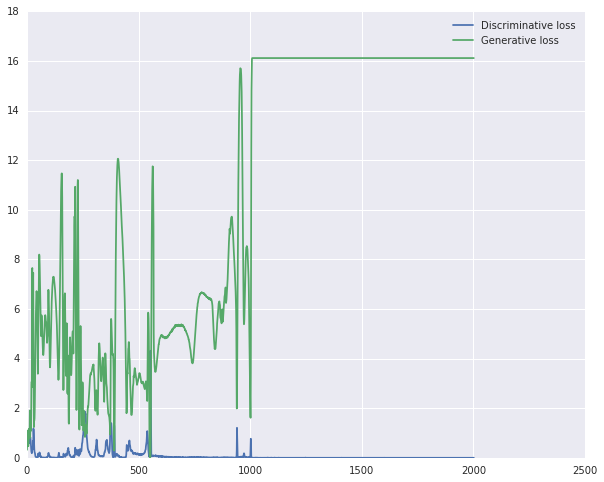

 38%|███▊      | 1501/4000 [1:40:47<2:52:29,  4.14s/it]


KeyboardInterrupt: 

In [ ]:
train_for_epochs(nb_epoch = 4000, plt_frq = 250, BATCH_SIZE = 1024)

In [67]:
noise_gen = np.random.uniform(0, 1, size=[10, 100])
generated = generator.predict(noise_gen).argmax(axis=2)
for g in generated:
    print(decode_smiles_from_indexes(g, charset))

Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Caaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
1+1